# Modelagem Sarima para Precipitação Mensal na Cidade de São Paulo

In [59]:
from dateutil.parser import parse 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import mplcursors
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

### Leitura do Arquivo Original - Precipitação em $m m^3$ por mês - Base BDMEP

Importante notar que os dados foram pré-tratados através do Excel, foi realiazada uma junção entre bases automáticas e manuais, visto que a literatura indicou que não haveria mudança significativa de precipitação total entre as bases.

In [60]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [61]:
#Lendo os Dados
rainfall_nodiff = pd.read_csv('C:/Users/Matheus Alves/Documents/git_tcc/time_series_precipitation/Dataset/dados_chuvas1.csv',parse_dates=[0], index_col=0, date_parser=parser)

In [62]:
#Amostra da Base (5 primeiros[antigos] e 13 últimos[recentes] valores)
print(rainfall_nodiff.iloc[np.r_[0:5, -13:0]])

            Precipitation
Date                     
1984-01-31          259.3
1984-02-29           32.5
1984-03-31           54.0
1984-04-30           96.8
1984-05-31          113.0
2021-01-31          215.5
2021-02-28          180.6
2021-03-31          138.4
2021-04-30           54.4
2021-05-31           44.4
2021-06-30           16.2
2021-07-31           39.4
2021-08-31           44.4
2021-09-30           39.5
2021-10-31           91.9
2021-11-30           98.6
2021-12-31          127.3
2022-01-31          308.5


In [73]:
# Estatísticas Básicas
rainfall_nodiff.describe()

,Precipitation
count,457.000000
mean,134.670460
std,108.082836
min,0.000000
25%,46.300000
50%,106.100000
75%,199.000000
max,607.900000


In [63]:
#Tornando Explícito as Datas de início e fim
start_date = datetime(1984,1,31)
end_date = datetime(2022,1,31)
rainfall_nodiff = rainfall_nodiff[start_date:end_date]

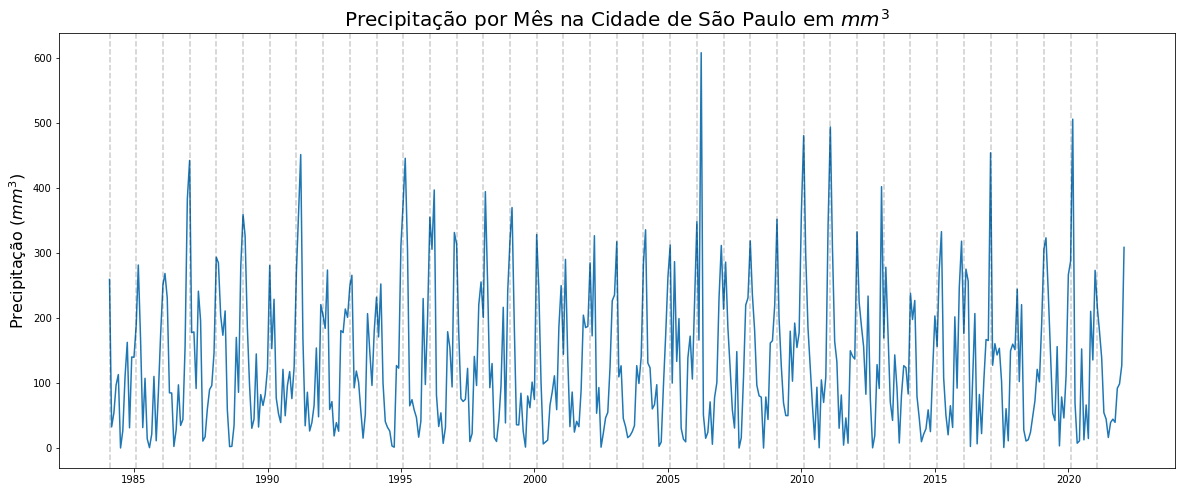

In [67]:
#Plotando o gráfico para as séries acima

plt.figure(figsize=(20,8))
plt.plot(rainfall_nodiff)
plt.title('Precipitação por Mês na Cidade de São Paulo em $mm^3$', fontsize=20)
plt.ylabel('Precipitação ($mm^3$)', fontsize=16)
#mplcursors.cursor(hover=True)
#Gera uma linha indicando novo ano, fortalecendo a suspeita de sasonalidade da população
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime('31-1-' + str(year)), color='k', linestyle='--', alpha=0.2)

### Realizando Test ADF para Avaliar Estacionariedade 


In [80]:
# Realizando Teste ADF 
result = adfuller(rainfall_nodiff)
print(f'Estatísticas ADF : {result[0]}')
print(f'p-valor: {result[1]}')
print(f'Valor Crítico: {result[4]}')

Estatísticas ADF : -4.506001282637859
p-valor: 0.0001917879351290753
Valor Crítico: {'1%': -3.4451642100030084, '5%': -2.8680716196949327, '10%': -2.5702491139112085}


A hipótese nula é rejeitada sendo que o p-valor é menor que o nível de significância 1%, portanto, podemos considerar essa série como estacionária.


<BarContainer object of 24 artists>

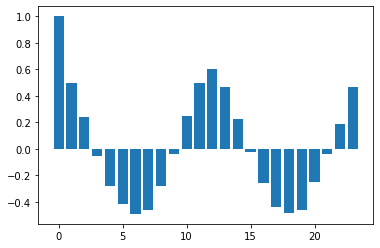

In [81]:
acf_vals = acf(rainfall_nodiff)
num_lags = 24
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 24 artists>

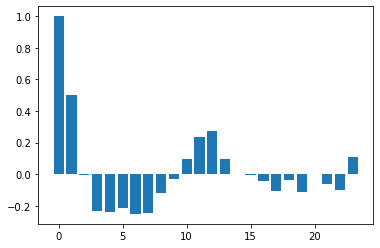

In [82]:
pacf_vals = pacf(rainfall_nodiff)
num_lags = 24
plt.bar(range(num_lags), pacf_vals[:num_lags])